# November 6th, 2021

**Motivation**: fft: more exploration, take a look at Spectrogram & Periodogram <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Sim1: random coefs -> recover

In [2]:
N = 600
fs = 10
delta_t = 1 / fs

t_idxs = np.arange(N * fs)
time = t_idxs * delta_t

fs, delta_t

(10, 0.1)

In [3]:
freqs = sp_fft.rfftfreq(len(t_idxs), 1/fs)

rng = get_rng()
x1_coefs = rng.normal(0, 1, size=len(freqs))
x2_coefs = rng.normal(0, 1, size=len(freqs))

len(freqs)

3001

In [4]:
x1_list = [
    x1_coefs[i] * np.cos(2 * np.pi * f * time)
    for i, f in enumerate(freqs)
]
x2_list = [
    x2_coefs[i] * np.cos(2 * np.pi * f * time)
    for i, f in enumerate(freqs)
]
x1 = sum(x1_list)
x2 = sum(x2_list)

x1.shape, x2.shape, time.shape

((6000,), (6000,), (6000,))

In [5]:
print('means: ', x1.mean(), x2.mean())
print('vars: ', x1.var(), x2.var())

means:  0.3047170797540701 0.6876921851178902

vars:  1525.0514630718474 1493.8855479335266

In [6]:
x1_coefs[0], x2_coefs[0]

(0.30471707975443135, 0.687692185117782)

In [7]:
0.5 * sum(a ** 2 for a in x1_coefs[1:]), 0.5 * sum(a ** 2 for a in x2_coefs[1:])

(1524.2714342232016, 1493.8841251977276)

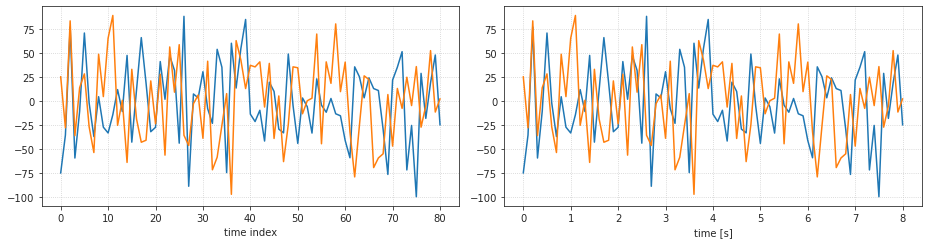

In [8]:
fig, axes = create_figure(1, 2, (13., 3.5))
intvl = range(0, 81)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl])
    ax.plot(_x, x2[intvl])
    ax.set_xlabel(lbl)
    ax.grid()
plt.show()

In [9]:
sp_stats.pearsonr(x1, x2)

(-0.01766466956819053, 0.17127418252441362)

In [10]:
y1 = sp_fft.rfft(x1, norm='forward')
y2 = sp_fft.rfft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

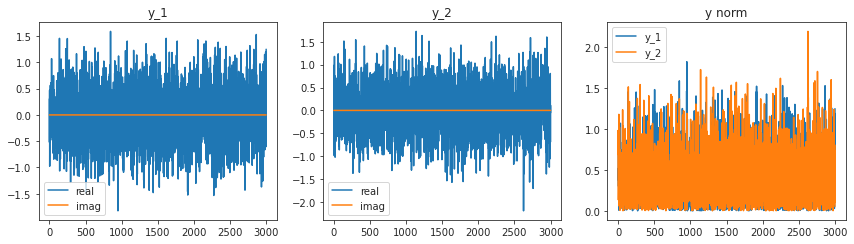

In [11]:
fig, axes = create_figure(1, 3, (12, 3.5))

for i, (_y, _y_norm) in enumerate([(y1, y1_norm), (y2, y2_norm)]):
    ax = axes[i]
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"y_{i+1}")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"y_{i+1}")
axes.ravel()[-1].set_title('y norm')
axes.ravel()[-1].legend()
plt.show()

In [12]:
y1.real.shape, x1_coefs.shape

((3001,), (3001,))

In [13]:
y1.real[0], x1_coefs[0]

(0.3047170797540701, 0.30471707975443135)

In [14]:
y1.real[1:-1] * 2, x1_coefs[1:-1]

(
    array([-1.03998411,  0.7504512 ,  0.94056472, ...,  2.33102467,
        0.81944757, -0.33412073]),
    array([-1.03998411,  0.7504512 ,  0.94056472, ...,  2.33102467,
        0.81944757, -0.33412073])
)

In [15]:
y1.real[-1], x1_coefs[-1]

(1.2490226968733258, 1.249022696873495)

In [16]:
freqs[0], freqs[-1]

(0.0, 5.0)

In [17]:
np.abs(y1.real[1:-1] * 2 - x1_coefs[1:-1]).sum()

9.632907433960308e-10

In [18]:
# This was used for fft (but is not useful anymore when used rff)

"""y1_compact = np.zeros(len(freqs), dtype=complex)
y1_compact[0] = y1[0]
for i in range(1, len(freqs)):
    j = len(y1) - i
    assert j >= i, "i covers first half, j the other"
    assert np.linalg.norm(y1[i]) == np.linalg.norm(y1[j])
    if i == j:
        y1_compact[i] = y1[i]
    else:
        y1_compact[i] = y1[i] + y1[j]"""

'y1_compact = np.zeros(len(freqs), dtype=complex)\ny1_compact[0] = y1[0]\nfor i in range(1, len(freqs)):\n    j = len(y1) - i\n    assert j >= i, "i covers first half, j the other"\n    assert np.linalg.norm(y1[i]) == np.linalg.norm(y1[j])\n    if i == j:\n        y1_compact[i] = y1[i]\n    else:\n        y1_compact[i] = y1[i] + y1[j]'

In [19]:
# y1_compact.real

In [20]:
# x1_coefs

In [21]:
# (x1_coefs - y1_compact.real).sum()

## Sim2: specific freqs

In [22]:
f1 = 2.5
f2 = 0.5
omega1 = 2 * np.pi * f1
omega2 = 2 * np.pi * f2

x1 = 0.8 * np.cos(omega1 * time) - 0.4 * np.cos(omega2 * time)
x2 = 0.8 * np.cos(omega1 * time) + 0.4 * np.cos(omega2 * time)

print(x1.var(), x2.var())

x1 = sp_stats.zscore(x1)
x2 = sp_stats.zscore(x2)

0.40000000000000674 0.3999999999999933

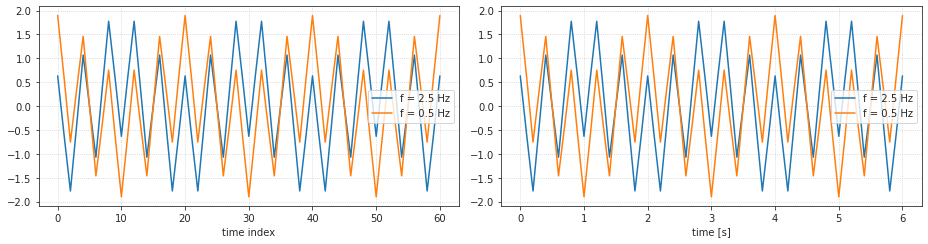

In [23]:
fig, axes = create_figure(1, 2, (13., 3.5))
intvl = range(0, fs * int(15 / f1) + 1)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl], label=f"f = {f1} Hz")
    ax.plot(_x, x2[intvl], label=f"f = {f2} Hz")
    ax.set_xlabel(lbl)
    ax.legend()
    ax.grid()
plt.show()

In [24]:
x1.mean(), x2.mean()

(4.5889218351173137e-17, -2.960594732333751e-17)

In [25]:
x1.std(), x2.std()

(1.0, 1.0)

In [26]:
sp_stats.pearsonr(x1, x2)

(0.5999999999999999, 0.0)

In [27]:
y1 = sp_fft.fft(x1, norm='forward')
y2 = sp_fft.fft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

In [28]:
y1.shape, y2.shape

((6000,), (6000,))

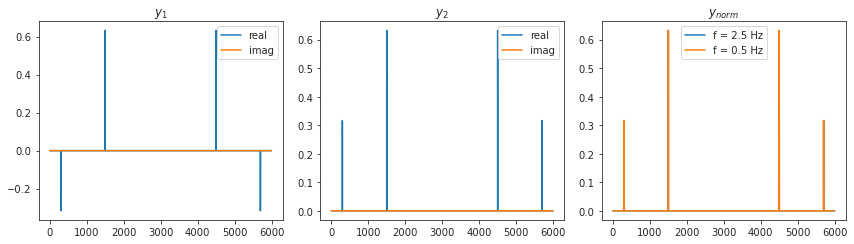

In [29]:
fig, axes = create_figure(1, 3, (12, 3.5))

for i, (ax, (_y, _y_norm, _f)) in enumerate(zip(axes.ravel()[:2], [(y1, y1_norm, f1), (y2, y2_norm, f2)])):
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"$y_{i+1}$")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"f = {_f} Hz")
axes.ravel()[-1].set_title('$y_{norm}$')
axes.ravel()[-1].legend()
plt.show()

(-0.1, 0.1)

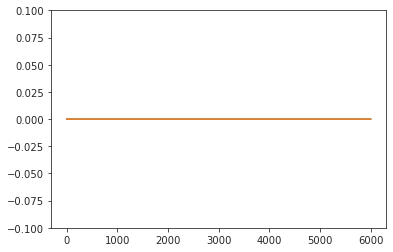

In [30]:
plt.plot(y1.imag)
plt.plot(y2.imag)
plt.ylim(-0.1, 0.1)

In [31]:
c = y1.conj() * y2
c.sum()

(0.6000000000000001+9.466330862652142e-30j)

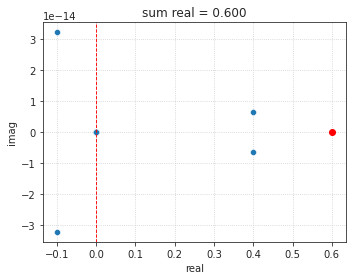

In [32]:
fig, ax = create_figure(1, 1, (5, 4))

sns.scatterplot(x=c.real, y=c.imag, ax=ax)
ax.set_xlabel('real')
ax.set_ylabel('imag')
ax.grid()

ax.plot(c.sum().real, c.sum().imag, marker='o', color='r')
ax.axvline(0, color='r', ls='--', lw=0.9)
ax.set_title(f"sum real = {c.sum().real:0.3f}")

plt.show()

In [33]:
np.argmin(np.abs(freqs - 2.5))

1500

In [34]:
freqs[1500]

2.5

In [35]:
band_fw = range(1499, 1502)
band_bw = range(len(time) - band_fw.stop + 1, len(time) - band_fw.start + 1)
band = list(itertools.chain(band_fw, band_bw))
band

[1499, 1500, 1501, 4499, 4500, 4501]

In [36]:
c[band].sum()

(0.8+1.7380408726613466e-31j)

In [37]:
np.argmin(np.abs(freqs - 0.5))

300

In [38]:
freqs[300]

0.5

In [39]:
band_fw = range(299, 302)
band_bw = range(len(time) - band_fw.stop + 1, len(time) - band_fw.start + 1)
band = list(itertools.chain(band_fw, band_bw))
band

[299, 300, 301, 5699, 5700, 5701]

In [40]:
c[band].sum()

(-0.19999999999999998+2.9161882814699833e-30j)

### Do same thing but with real fft (rfft)

In [41]:
y1 = sp_fft.rfft(x1, norm='forward')
y2 = sp_fft.rfft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

In [42]:
y1.shape, y2.shape

((3001,), (3001,))

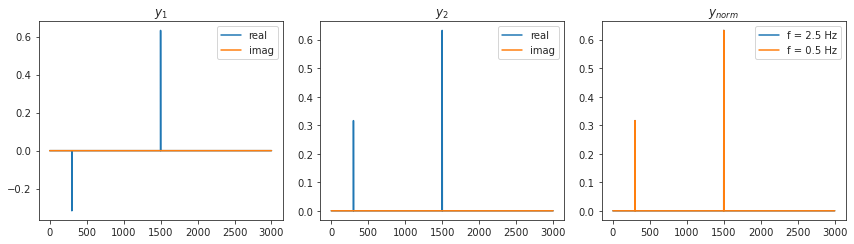

In [43]:
fig, axes = create_figure(1, 3, (12, 3.5))

for i, (ax, (_y, _y_norm, _f)) in enumerate(zip(axes.ravel()[:2], [(y1, y1_norm, f1), (y2, y2_norm, f2)])):
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"$y_{i+1}$")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"f = {_f} Hz")
axes.ravel()[-1].set_title('$y_{norm}$')
axes.ravel()[-1].legend()
plt.show()

(-0.1, 0.1)

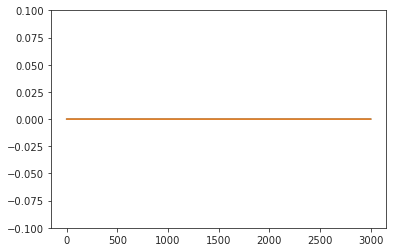

In [44]:
plt.plot(y1.imag)
plt.plot(y2.imag)
plt.ylim(-0.1, 0.1)

In [45]:
c = y1.conj() * y2
2 * c.sum()

(0.6000000000000001+5.151264748550044e-14j)

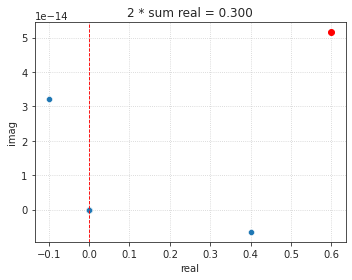

In [46]:
fig, ax = create_figure(1, 1, (5, 4))

sns.scatterplot(x=c.real, y=c.imag, ax=ax)
ax.set_xlabel('real')
ax.set_ylabel('imag')
ax.grid()

ax.plot(2 * c.sum().real, 2 * c.sum().imag, marker='o', color='r')
ax.axvline(0, color='r', ls='--', lw=0.9)
ax.set_title(f"2 * sum real = {c.sum().real:0.3f}")

plt.show()

In [47]:
np.argmin(np.abs(freqs - 2.5))

1500

In [48]:
freqs[1500]

2.5

In [49]:
band = range(1499, 1502)
band

range(1499, 1502)

In [50]:
2 * c[band].sum()

(0.8-1.2959635151821556e-14j)

In [51]:
np.argmin(np.abs(freqs - 0.5))

300

In [52]:
freqs[300]

0.5

In [53]:
band = range(299, 302)
band

range(299, 302)

In [54]:
2 * c[band].sum()

(-0.19999999999999998+6.447228263732364e-14j)

### Spectrogram & Periodogram

In [55]:
f1, t1, sxx1 = sp_sig.spectrogram(x1, fs)
f2, t2, sxx2 = sp_sig.spectrogram(x2, fs)

f2.shape, t2.shape, sxx2.shape

((129,), (26,), (129, 26))

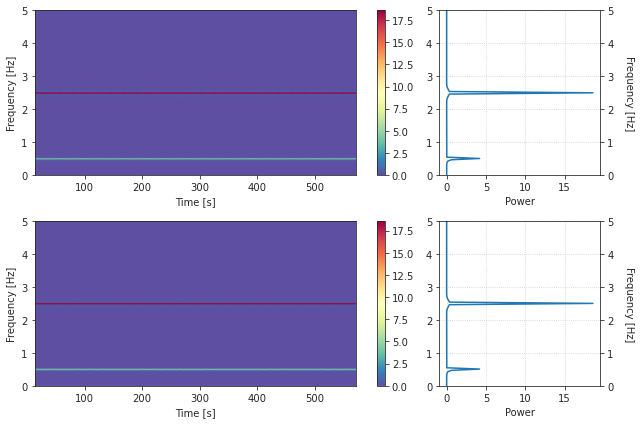

In [56]:
fig, axes = create_figure(2, 2, (9, 6), sharey='row', gridspec_kw={'width_ratios': [1, 0.4]})

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(
        _t, _f, _sxx, shading='gouraud', cmap='Spectral_r')
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 0].set_xlabel('Time [s]')
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=True,
        labelright=True,
    )
    axes[i, 1].set_xlabel('Power')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()

plt.show()

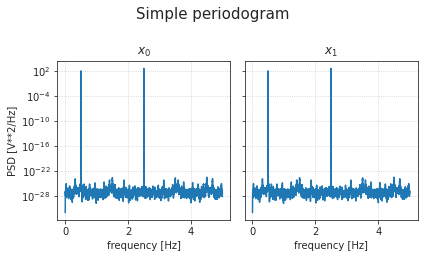

In [57]:
fig, axes = create_figure(1, 2, (6, 3.5), sharey='row')

f1, pxx1 = sp_sig.periodogram(x1, fs)
f2, pxx2 = sp_sig.periodogram(x2, fs)

for i, (ax, (_f, _pxx)) in enumerate(zip(axes.flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_xlabel('frequency [Hz]')
    ax.set_title(f"$x_{i}$")
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()
fig.suptitle('Simple periodogram', fontsize=15, y=1.01)
plt.show()

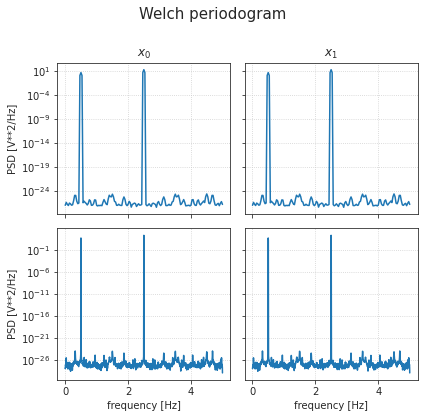

1st row:  nperseg = len(time) // 20 = 300
2nd row:  nperseg = len(time) // 2 = 3000

In [58]:
fig, axes = create_figure(2, 2, (6, 5.7), sharey='row', sharex='all')


nperseg = len(time) // 20
msg = f"1st row:  nperseg = len(time) // 20 = {nperseg}\n"
f1, pxx1 = sp_sig.welch(x1, fs, nperseg=nperseg)
f2, pxx2 = sp_sig.welch(x2, fs, nperseg=nperseg)

for i, (ax, (_f, _pxx)) in enumerate(zip(axes[0].flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_title(f"$x_{i}$")
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()


nperseg = len(time) // 2
msg += f"2nd row:  nperseg = len(time) // 2 = {nperseg}\n"
f1, pxx1 = sp_sig.welch(x1, fs, nperseg=nperseg)
f2, pxx2 = sp_sig.welch(x2, fs, nperseg=nperseg)
    
for i, (ax, (_f, _pxx)) in enumerate(zip(axes[1].flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_xlabel('frequency [Hz]')
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()
fig.suptitle('Welch periodogram', fontsize=15, y=1.01)
plt.show()


print()
print(msg)

## Sim1: different coefs -> recover

In [59]:
N = 600
fs = 10
delta_t = 1 / fs

t_idxs = np.arange(N * fs)
time = t_idxs * delta_t

fs, delta_t

(10, 0.1)

In [60]:
freqs = sp_fft.rfftfreq(len(t_idxs), 1/fs)

rng = get_rng()
x1_coefs = rng.standard_t(10, size=len(freqs))
x2_coefs = rng.standard_t(100, size=len(freqs))

len(freqs)

3001

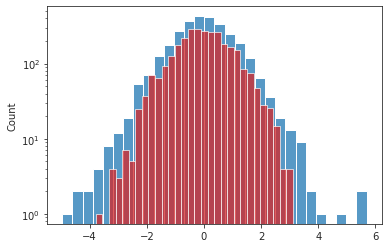

In [61]:
sns.histplot(x1_coefs, bins=30, color='C0')
sns.histplot(x2_coefs, bins=30, color='C3')
plt.yscale('log')

In [62]:
x1_list = [
    x1_coefs[i] * np.cos(2 * np.pi * f * time)
    for i, f in enumerate(freqs)
]
x2_list = [
    x2_coefs[i] * np.cos(2 * np.pi * f * time)
    for i, f in enumerate(freqs)
]
x1 = sum(x1_list)
x2 = sum(x2_list)

x1.shape, x2.shape, time.shape

((6000,), (6000,), (6000,))

In [63]:
print('means: ', x1.mean(), x2.mean())
print('vars: ', x1.var(), x2.var())

means:  0.4100401953150688 -2.8149030010030245

vars:  1871.1402615998677 1472.9130282772257

In [64]:
x1_coefs[0], x2_coefs[0]

(0.4100401953152789, -2.814903001002699)

In [65]:
0.5 * sum(a ** 2 for a in x1_coefs[1:]), 0.5 * sum(a ** 2 for a in x2_coefs[1:])

(1870.2118061457463, 1472.8506091385698)

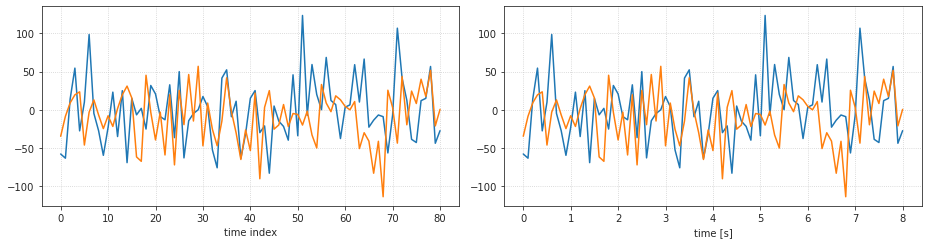

In [66]:
fig, axes = create_figure(1, 2, (13., 3.5))
intvl = range(0, 81)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl])
    ax.plot(_x, x2[intvl])
    ax.set_xlabel(lbl)
    ax.grid()
plt.show()

In [67]:
sp_stats.pearsonr(x1, x2)

(-0.020916389197646688, 0.10522880047020193)

In [68]:
y1 = sp_fft.rfft(x1, norm='forward')
y2 = sp_fft.rfft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

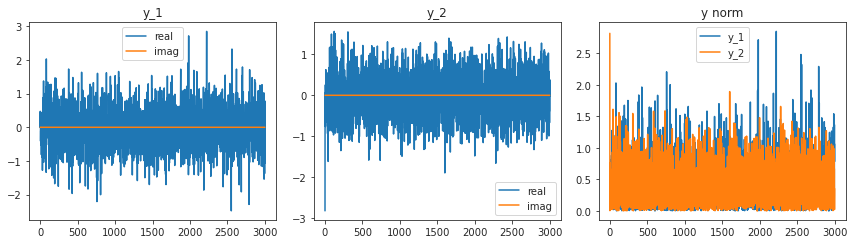

In [69]:
fig, axes = create_figure(1, 3, (12, 3.5))

for i, (_y, _y_norm) in enumerate([(y1, y1_norm), (y2, y2_norm)]):
    ax = axes[i]
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"y_{i+1}")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"y_{i+1}")
axes.ravel()[-1].set_title('y norm')
axes.ravel()[-1].legend()
plt.show()

In [70]:
y1.real.shape, x1_coefs.shape

((3001,), (3001,))

In [71]:
y1.real[0], x1_coefs[0]

(0.41004019531506886, 0.4100401953152789)

In [72]:
y1.real[1:-1] * 2, x1_coefs[1:-1]

(
    array([ 0.94546385, -0.02149125,  0.79294169, ..., -0.55740608,
       -2.12685419,  1.55920139]),
    array([ 0.94546385, -0.02149125,  0.79294169, ..., -0.55740608,
       -2.12685419,  1.55920139])
)

In [73]:
y1.real[-1], x1_coefs[-1]

(-1.3626851830818607, -1.3626851830813167)

In [74]:
freqs[0], freqs[-1]

(0.0, 5.0)

In [75]:
np.abs(y1.real[1:-1] * 2 - x1_coefs[1:-1]).sum()

1.0935817277505765e-09

### Spectrogram & Periodogram

In [76]:
f1, t1, sxx1 = sp_sig.spectrogram(x1, fs)
f2, t2, sxx2 = sp_sig.spectrogram(x2, fs)

f2.shape, t2.shape, sxx2.shape

((129,), (26,), (129, 26))

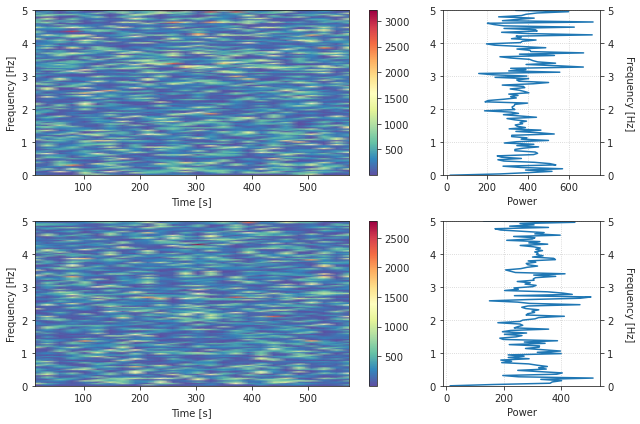

In [77]:
fig, axes = create_figure(2, 2, (9, 6), sharey='row', gridspec_kw={'width_ratios': [1, 0.4]})

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(
        _t, _f, _sxx,
        shading='gouraud',
        cmap='Spectral_r',
    )
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 0].set_xlabel('Time [s]')
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=True,
        labelright=True,
    )
    axes[i, 1].set_xlabel('Power')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()

plt.show()

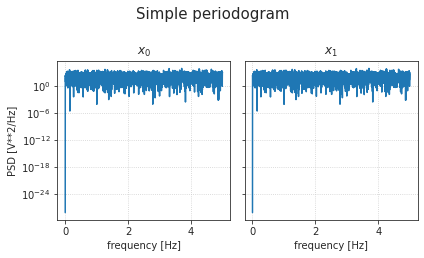

In [78]:
fig, axes = create_figure(1, 2, (6, 3.5), sharey='row')

f1, pxx1 = sp_sig.periodogram(x1, fs)
f2, pxx2 = sp_sig.periodogram(x2, fs)

for i, (ax, (_f, _pxx)) in enumerate(zip(axes.flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_xlabel('frequency [Hz]')
    ax.set_title(f"$x_{i}$")
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()
fig.suptitle('Simple periodogram', fontsize=15, y=1.01)
plt.show()

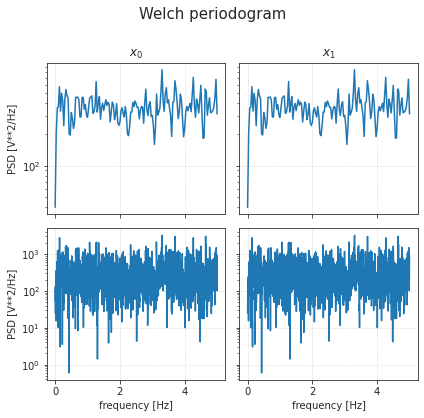

1st row:  nperseg = len(time) // 20 = 300
2nd row:  nperseg = len(time) // 2 = 3000

In [79]:
fig, axes = create_figure(2, 2, (6, 5.7), sharey='row', sharex='all')


nperseg = len(time) // 20
msg = f"1st row:  nperseg = len(time) // 20 = {nperseg}\n"
f1, pxx1 = sp_sig.welch(x1, fs, nperseg=nperseg)
f2, pxx2 = sp_sig.welch(x2, fs, nperseg=nperseg)

for i, (ax, (_f, _pxx)) in enumerate(zip(axes[0].flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_title(f"$x_{i}$")
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()


nperseg = len(time) // 2
msg += f"2nd row:  nperseg = len(time) // 2 = {nperseg}\n"
f1, pxx1 = sp_sig.welch(x1, fs, nperseg=nperseg)
f2, pxx2 = sp_sig.welch(x2, fs, nperseg=nperseg)
    
for i, (ax, (_f, _pxx)) in enumerate(zip(axes[1].flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_xlabel('frequency [Hz]')
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()
fig.suptitle('Welch periodogram', fontsize=15, y=1.01)
plt.show()


print()
print(msg)

## Sim1: standard t coefs -> mean substracted

In [80]:
N = 600
fs = 10
delta_t = 1 / fs

t_idxs = np.arange(N * fs)
time = t_idxs * delta_t

fs, delta_t

(10, 0.1)

In [81]:
freqs = sp_fft.rfftfreq(len(t_idxs), 1/fs)

rng = get_rng()
x1_coefs = rng.standard_t(10, size=len(freqs))
x2_coefs = rng.standard_t(100, size=len(freqs))
x1_coefs[0] = 0
x2_coefs[0] = 0

len(freqs)

3001

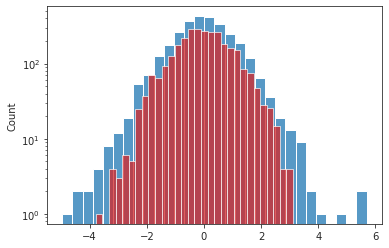

In [82]:
sns.histplot(x1_coefs, bins=30, color='C0')
sns.histplot(x2_coefs, bins=30, color='C3')
plt.yscale('log')

In [83]:
x1_list = [
    x1_coefs[i] * np.cos(2 * np.pi * f * time)
    for i, f in enumerate(freqs)
]
x2_list = [
    x2_coefs[i] * np.cos(2 * np.pi * f * time)
    for i, f in enumerate(freqs)
]
x1 = sum(x1_list)
x2 = sum(x2_list)

x1.shape, x2.shape, time.shape

((6000,), (6000,), (6000,))

In [84]:
print('means: ', x1.mean(), x2.mean())
print('vars: ', x1.var(), x2.var())

means:  -2.098943241435336e-13 -3.257885812975777e-13

vars:  1871.1402615998677 1472.9130282772257

In [85]:
x1_coefs[0], x2_coefs[0]

(0.0, 0.0)

In [86]:
0.5 * sum(a ** 2 for a in x1_coefs[1:]), 0.5 * sum(a ** 2 for a in x2_coefs[1:])

(1870.2118061457463, 1472.8506091385698)

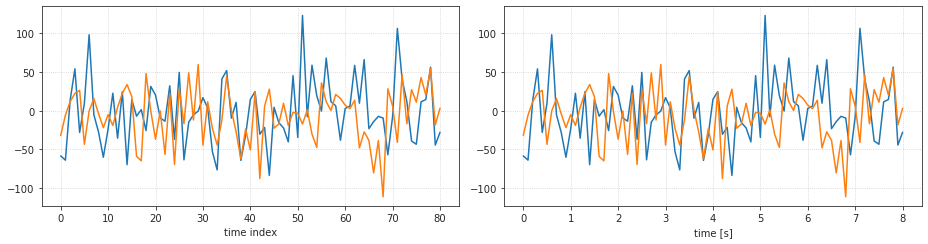

In [87]:
fig, axes = create_figure(1, 2, (13., 3.5))
intvl = range(0, 81)

for i, ax in enumerate(axes.flat):
    if i == 0:
        _x = t_idxs[intvl]
        lbl = 'time index'
    else:
        _x = time[intvl]
        lbl = 'time [s]'
    ax.plot(_x, x1[intvl])
    ax.plot(_x, x2[intvl])
    ax.set_xlabel(lbl)
    ax.grid()
plt.show()

In [88]:
sp_stats.pearsonr(x1, x2)

(-0.020916389197646667, 0.10522880047020193)

In [89]:
y1 = sp_fft.rfft(x1, norm='forward')
y2 = sp_fft.rfft(x2, norm='forward')

y1_norm = np.linalg.norm(y1.reshape(1, -1), ord=2, axis=0)
y2_norm = np.linalg.norm(y2.reshape(1, -1), ord=2, axis=0)

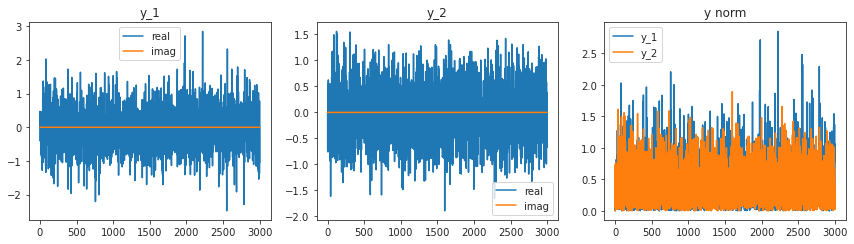

In [90]:
fig, axes = create_figure(1, 3, (12, 3.5))

for i, (_y, _y_norm) in enumerate([(y1, y1_norm), (y2, y2_norm)]):
    ax = axes[i]
    ax.plot(_y.real, label='real')
    ax.plot(_y.imag, label='imag')
    ax.set_title(f"y_{i+1}")
    ax.legend()
    axes.ravel()[-1].plot(_y_norm, label=f"y_{i+1}")
axes.ravel()[-1].set_title('y norm')
axes.ravel()[-1].legend()
plt.show()

In [91]:
y1.real.shape, x1_coefs.shape

((3001,), (3001,))

In [92]:
y1.real[0], x1_coefs[0]

(-2.0994169365925094e-13, 0.0)

In [93]:
y1.real[1:-1] * 2, x1_coefs[1:-1]

(
    array([ 0.94546385, -0.02149125,  0.79294169, ..., -0.55740608,
       -2.12685419,  1.55920139]),
    array([ 0.94546385, -0.02149125,  0.79294169, ..., -0.55740608,
       -2.12685419,  1.55920139])
)

In [94]:
y1.real[-1], x1_coefs[-1]

(-1.3626851830818605, -1.3626851830813167)

In [95]:
freqs[0], freqs[-1]

(0.0, 5.0)

In [96]:
np.abs(y1.real[1:-1] * 2 - x1_coefs[1:-1]).sum()

1.0936042070698723e-09

### Spectrogram & Periodogram

In [97]:
f1, t1, sxx1 = sp_sig.spectrogram(x1, fs)
f2, t2, sxx2 = sp_sig.spectrogram(x2, fs)

f2.shape, t2.shape, sxx2.shape

((129,), (26,), (129, 26))

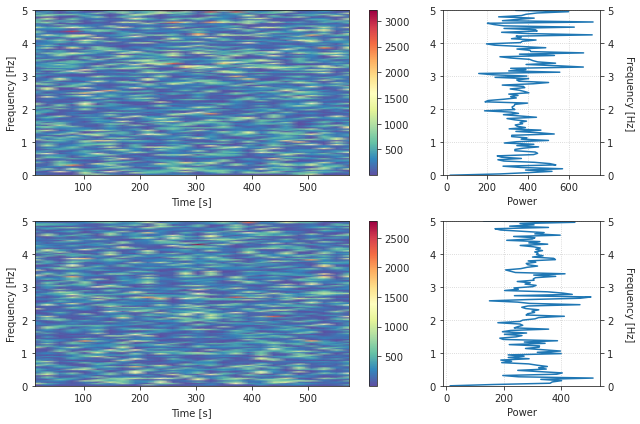

In [98]:
fig, axes = create_figure(2, 2, (9, 6), sharey='row', gridspec_kw={'width_ratios': [1, 0.4]})

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(
        _t, _f, _sxx,
        shading='gouraud',
        cmap='Spectral_r',
    )
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 0].set_xlabel('Time [s]')
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=True,
        labelright=True,
    )
    axes[i, 1].set_xlabel('Power')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()

plt.show()

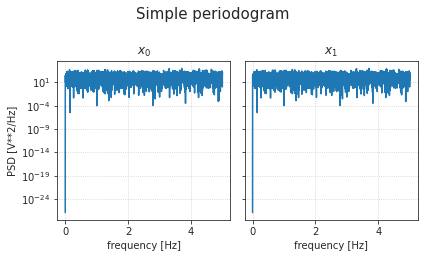

In [99]:
fig, axes = create_figure(1, 2, (6, 3.5), sharey='row')

f1, pxx1 = sp_sig.periodogram(x1, fs)
f2, pxx2 = sp_sig.periodogram(x2, fs)

for i, (ax, (_f, _pxx)) in enumerate(zip(axes.flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_xlabel('frequency [Hz]')
    ax.set_title(f"$x_{i}$")
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()
fig.suptitle('Simple periodogram', fontsize=15, y=1.01)
plt.show()

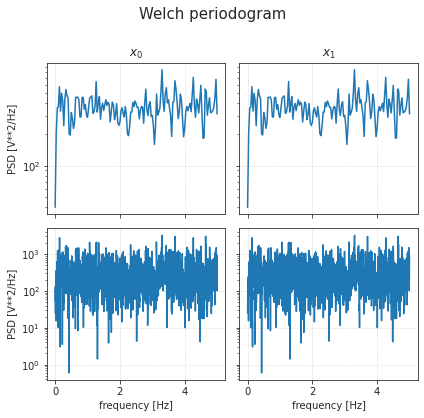

1st row:  nperseg = len(time) // 20 = 300
2nd row:  nperseg = len(time) // 2 = 3000

In [100]:
fig, axes = create_figure(2, 2, (6, 5.7), sharey='row', sharex='all')


nperseg = len(time) // 20
msg = f"1st row:  nperseg = len(time) // 20 = {nperseg}\n"
f1, pxx1 = sp_sig.welch(x1, fs, nperseg=nperseg)
f2, pxx2 = sp_sig.welch(x2, fs, nperseg=nperseg)

for i, (ax, (_f, _pxx)) in enumerate(zip(axes[0].flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_title(f"$x_{i}$")
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()


nperseg = len(time) // 2
msg += f"2nd row:  nperseg = len(time) // 2 = {nperseg}\n"
f1, pxx1 = sp_sig.welch(x1, fs, nperseg=nperseg)
f2, pxx2 = sp_sig.welch(x2, fs, nperseg=nperseg)
    
for i, (ax, (_f, _pxx)) in enumerate(zip(axes[1].flat, [(f1, pxx1), (f2, pxx2)])):
    ax.semilogy(f1, pxx1)
    ax.set_xlabel('frequency [Hz]')
    if i == 0:
        ax.set_ylabel('PSD [V**2/Hz]')
    ax.grid()
fig.suptitle('Welch periodogram', fontsize=15, y=1.01)
plt.show()


print()
print(msg)

### Experiment with different windows

In [113]:
f1, t1, sxx1 = sp_sig.spectrogram(x1, fs, nperseg=300, window='blackman')
f2, t2, sxx2 = sp_sig.spectrogram(x2, fs, nperseg=300, window='blackman')

f2.shape, t2.shape, sxx2.shape

((151,), (22,), (151, 22))

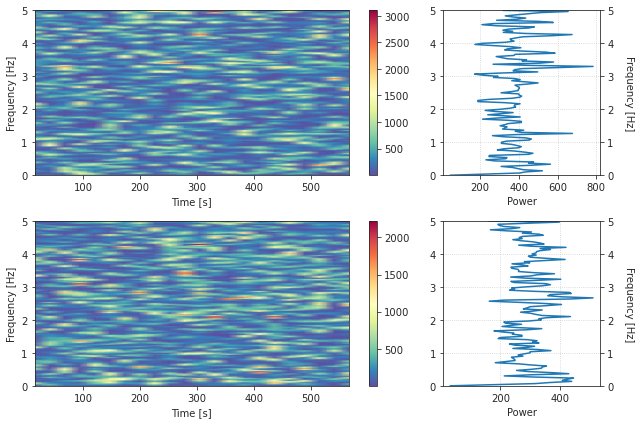

In [114]:
fig, axes = create_figure(2, 2, (9, 6), sharey='row', gridspec_kw={'width_ratios': [1, 0.4]})

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(
        _t, _f, _sxx,
        shading='gouraud',
        cmap='Spectral_r',
    )
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 0].set_xlabel('Time [s]')
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=True,
        labelright=True,
    )
    axes[i, 1].set_xlabel('Power')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()

plt.show()

In [118]:
f1, t1, sxx1 = sp_sig.spectrogram(x1, fs, nperseg=300, window=('tukey', 0.5))
f2, t2, sxx2 = sp_sig.spectrogram(x2, fs, nperseg=300, window=('tukey', 0.5))

f2.shape, t2.shape, sxx2.shape

((151,), (22,), (151, 22))

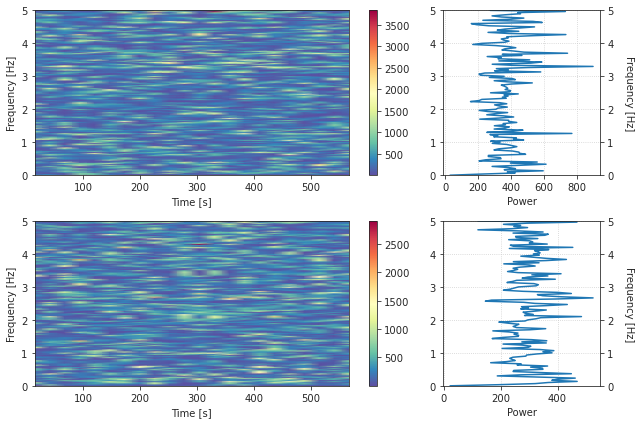

In [119]:
fig, axes = create_figure(2, 2, (9, 6), sharey='row', gridspec_kw={'width_ratios': [1, 0.4]})

for i, (_f, _t, _sxx) in enumerate([(f1, t1, sxx1), (f2, t2, sxx2)]):
    im = axes[i, 0].pcolormesh(
        _t, _f, _sxx,
        shading='gouraud',
        cmap='Spectral_r',
    )
    axes[i, 0].set_ylabel('Frequency [Hz]')
    axes[i, 0].set_xlabel('Time [s]')
    plt.colorbar(im, ax=axes[i, 0])

    axes[i, 1].plot(_sxx.mean(1), _f)
    axes[i, 1].tick_params(
        axis='y',
        which='both',
        left=True,
        right=True,
        labelleft=True,
        labelright=True,
    )
    axes[i, 1].set_xlabel('Power')
    axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
    axes[i, 1].yaxis.set_label_position('right')
    axes[i, 1].grid()

plt.show()